In [71]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/SurveyData.csv')

rename_mapping = {
    'Timestamp': 'Timestamp',
    'I consent and am aware that my responses in this survey will be collected for data analysis': 'Consent',
    'What is your age?': 'Age',
    'What is your gender': 'Gender',
    'When was your last theme park visit? (MM/YYYY)': 'LastVisit',
    'Were there any special occasions that prompted the visit? (etc Christmas, school holidays, weekends)': 'SpecialOccasionFlag',
    'If you answered yes for above, which special occasion was it?': 'SpecialOccasionType',
    'Which period of the year do you normally visit the theme park? ': 'VisitPeriodYear',
    'Which period of the day do you normally visit the theme park? (Opening time, early afternoon, late afternoon, evening)': 'VisitPeriodDay',
    'Which theme parks have you visited?': 'VisitedParks',
    'If you answered "Others", please state the theme park': 'OtherPark',
    'How frequently do you visit theme parks?': 'VisitFrequency',
    'What are your considerations when planning your theme park visits?': 'PlanningConsiderations',
    'Which attractions or rides do you plan to visit when you go visit a theme park? Pick up to 2-3': 'PlannedAttractions',
    'If you stated others, please state the attraction': 'OtherPlannedAttraction',
    'Which attractions or rides do you end up visiting? Pick up to 2-3': 'VisitedAttractions',
    'If you stated others, please state the attraction.1': 'OtherVisitedAttraction',
    'How was the WiFi quality in the theme park?': 'WiFiQuality',
    'What are some pain points you have experienced?': 'PainPoints',
    'If you answered "Others", please state the pain points': 'OtherPainPoints',
    'What do you hope can be implemented to overcome said challenges?': 'SuggestedImprovements'
}


df.rename(columns=rename_mapping, inplace=True)
df.drop(columns=['Timestamp', 'Consent'], inplace=True)
print("Renamed columns:")
print(df.columns.tolist())

Renamed columns:
['Age', 'Gender', 'LastVisit', 'SpecialOccasionFlag', 'SpecialOccasionType', 'VisitPeriodYear', 'VisitPeriodDay', 'VisitedParks', 'OtherPark', 'VisitFrequency', 'PlanningConsiderations', 'PlannedAttractions', 'OtherPlannedAttraction', 'VisitedAttractions', 'OtherVisitedAttraction', 'WiFiQuality', 'PainPoints', 'OtherPainPoints', 'SuggestedImprovements']


In [72]:
from datetime import timedelta

np.random.seed(3101)
# --- Set Target and Prepare for Synthetic Generation ---
target_total = 200
num_synthetic = target_total - len(df)
print(f"Real responses: {len(df)}; Synthetic responses to generate: {num_synthetic}")

synthetic_rows = []

# For Age (numeric)
age_series = pd.to_numeric(df['Age'], errors='coerce').dropna()
age_mean = age_series.mean() if not age_series.empty else 40
age_std = age_series.std() if not age_series.empty else 10

# For LastVisit (dates in MM/YYYY)
df['LastVisit_dt'] = pd.to_datetime(df['LastVisit'], format='%m/%Y', errors='coerce')
date_series = df['LastVisit_dt'].dropna()
min_date = date_series.min() if not date_series.empty else pd.to_datetime("01/2000", format='%m/%Y')
max_date = date_series.max() if not date_series.empty else pd.to_datetime("12/2020", format='%m/%Y')
date_range_days = (max_date - min_date).days

# For categorical columns, we calculate the empirical probability distributions:
def get_category_probs(col):
    vals = df[col].dropna()
    if vals.empty:
        return None
    return vals.value_counts(normalize=True)

gender_probs = get_category_probs('Gender')
visitfreq_probs = get_category_probs('VisitFrequency')
wifi_probs = get_category_probs('WiFiQuality')
specialOccasion_probs = get_category_probs('SpecialOccasionFlag')

#Synthetic Data Generation
for i in range(num_synthetic):
    synthetic_row = {}
    
    # Generate Age using a normal distribution
    synthetic_age = int(np.clip(np.random.normal(age_mean, age_std), 10, 100))
    synthetic_row['Age'] = synthetic_age

    # Generate Gender using empirical probabilities
    if gender_probs is not None:
        synthetic_row['Gender'] = np.random.choice(gender_probs.index, p=gender_probs.values)
    else:
        synthetic_row['Gender'] = ''

    # Generate LastVisit as a random date between min and max, then format as MM/YYYY
    if date_range_days > 0:
        rand_days = np.random.randint(0, date_range_days + 1)
        synthetic_date = min_date + timedelta(days=rand_days)
        synthetic_row['LastVisit'] = synthetic_date.strftime('%m/%Y')
    else:
        synthetic_row['LastVisit'] = ''
    
    # For SpecialOccasionFlag (categorical)
    if specialOccasion_probs is not None:
        synthetic_row['SpecialOccasionFlag'] = np.random.choice(specialOccasion_probs.index, p=specialOccasion_probs.values)
    else:
        synthetic_row['SpecialOccasionFlag'] = ''
    
    # For SpecialOccasionType (free text), generate by sampling a random existing value
    if not df['SpecialOccasionType'].dropna().empty:
        synthetic_row['SpecialOccasionType'] = np.random.choice(df['SpecialOccasionType'].dropna().values)
    else:
        synthetic_row['SpecialOccasionType'] = ''
    
    # For VisitPeriodYear (categorical)
    if not df['VisitPeriodYear'].dropna().empty:
        synthetic_row['VisitPeriodYear'] = np.random.choice(df['VisitPeriodYear'].dropna().values)
    else:
        synthetic_row['VisitPeriodYear'] = ''
    
    # For VisitPeriodDay (categorical)
    if not df['VisitPeriodDay'].dropna().empty:
        synthetic_row['VisitPeriodDay'] = np.random.choice(df['VisitPeriodDay'].dropna().values)
    else:
        synthetic_row['VisitPeriodDay'] = ''
    
    # For VisitedParks (free text)
    if not df['VisitedParks'].dropna().empty:
        synthetic_row['VisitedParks'] = np.random.choice(df['VisitedParks'].dropna().values)
    else:
        synthetic_row['VisitedParks'] = ''
    
    # For OtherPark (free text)
    if not df['OtherPark'].dropna().empty:
        synthetic_row['OtherPark'] = np.random.choice(df['OtherPark'].dropna().values)
    else:
        synthetic_row['OtherPark'] = ''
    
    # For VisitFrequency (categorical)
    if visitfreq_probs is not None:
        synthetic_row['VisitFrequency'] = np.random.choice(visitfreq_probs.index, p=visitfreq_probs.values)
    else:
        synthetic_row['VisitFrequency'] = ''
    
    # For PlanningConsiderations (free text)
    if not df['PlanningConsiderations'].dropna().empty:
        synthetic_row['PlanningConsiderations'] = np.random.choice(df['PlanningConsiderations'].dropna().values)
    else:
        synthetic_row['PlanningConsiderations'] = ''
    
    # For PlannedAttractions (free text)
    if not df['PlannedAttractions'].dropna().empty:
        synthetic_row['PlannedAttractions'] = np.random.choice(df['PlannedAttractions'].dropna().values)
    else:
        synthetic_row['PlannedAttractions'] = ''
    
    # For OtherPlannedAttraction (free text)
    if not df['OtherPlannedAttraction'].dropna().empty:
        synthetic_row['OtherPlannedAttraction'] = np.random.choice(df['OtherPlannedAttraction'].dropna().values)
    else:
        synthetic_row['OtherPlannedAttraction'] = ''
    
    # For VisitedAttractions (free text)
    if not df['VisitedAttractions'].dropna().empty:
        synthetic_row['VisitedAttractions'] = np.random.choice(df['VisitedAttractions'].dropna().values)
    else:
        synthetic_row['VisitedAttractions'] = ''
    
    # For OtherVisitedAttraction (free text)
    if not df['OtherVisitedAttraction'].dropna().empty:
        synthetic_row['OtherVisitedAttraction'] = np.random.choice(df['OtherVisitedAttraction'].dropna().values)
    else:
        synthetic_row['OtherVisitedAttraction'] = ''
    
    # For WiFiQuality (categorical)
    if wifi_probs is not None:
        synthetic_row['WiFiQuality'] = np.random.choice(wifi_probs.index, p=wifi_probs.values)
    else:
        synthetic_row['WiFiQuality'] = ''
    
    # For PainPoints (free text)
    if not df['PainPoints'].dropna().empty:
        synthetic_row['PainPoints'] = np.random.choice(df['PainPoints'].dropna().values)
    else:
        synthetic_row['PainPoints'] = ''
    
    # For OtherPainPoints (free text)
    if not df['OtherPainPoints'].dropna().empty:
        synthetic_row['OtherPainPoints'] = np.random.choice(df['OtherPainPoints'].dropna().values)
    else:
        synthetic_row['OtherPainPoints'] = ''
    
    # For SuggestedImprovements (free text)
    if not df['SuggestedImprovements'].dropna().empty:
        synthetic_row['SuggestedImprovements'] = np.random.choice(df['SuggestedImprovements'].dropna().values)
    else:
        synthetic_row['SuggestedImprovements'] = ''
    
    synthetic_rows.append(synthetic_row)

df_synthetic = pd.DataFrame(synthetic_rows)
df_combined = pd.concat([df.drop(columns=['LastVisit_dt']), df_synthetic], ignore_index=True)

# Save the combined dataset
#df_combined.to_csv('./data/Synthesised_Surveydata.csv', index=False)

df = df_combined

Real responses: 132; Synthetic responses to generate: 68


In [73]:
periods_list = ['Jan to Mar', 'Apr to Jun', 'Jul to Sept', 'Oct to Dec']

# One-hot encode the VisitPeriodYear column in a similar fashion to the rides encoding
for period in periods_list:
    df[period] = df['VisitPeriodYear'].apply(lambda x: 1 if isinstance(x, str) and period in x else 0)

# Mapping the time of day into numeric values
visit_mapping = {
    'Opening Time': 0,
    'Early Afternoon': 1,
    'Late Afternoon': 2,
    'Evening': 3
}

df['Visit'] = df['VisitPeriodDay'].map(visit_mapping)

# --- Mapping for Visit Frequency ---
frequency_mapping = {
    'More than 5 times a year': 0,
    '3 to 4 times a year': 1,
    '1 to 2 times a year': 2,
    'Once every 2 years': 3,
    'Once every 3 years': 4,
    'Once every 4 years': 5,
    'Once every 5 years': 6,
    'Less than once every 5 years': 7
}

df['Frequency'] = df['VisitFrequency'].map(frequency_mapping)

# --- One-Hot Encoding for Rides/Attractions ---
rides_list = [
    'Roller Coasters', 'Ferris Wheels', 'Bumper Cars', 'Immersive Experiences', 
    'Dark rides', 'Haunted Houses', 'Carousels', 'Drop Towers', 'Pendulum rides (eg. Viking ride)', 
    'Eateries', 'Others'
]

for ride in rides_list:
    df[ride] = df['VisitedAttractions'].apply(lambda x: 1 if isinstance(x, str) and ride in x else 0)

# --- One-Hot Encoding for Pain Points ---
pain_list = [
    'Long waiting times', 'Difficulty navigating the park', 'Poor crowd management', 
    'Lack of real time information about waiting times', 'Poor reception', 'Others'
]

for pain in pain_list:
    df[pain] = df['PainPoints'].apply(lambda x: 1 if isinstance(x, str) and pain in x else 0)


print(df.head())
print(df.columns.tolist())


   Age  Gender LastVisit SpecialOccasionFlag SpecialOccasionType  \
0   22  Female    Feb-25                 Yes           Exchange    
1   21  Female    Jul-24                 Yes     Summer holidays   
2   23    Male    Dec-22                  No                 NaN   
3   22  Female    Dec-17                 Yes   Christmas season    
4   22  Female    Dec-24                 Yes        exch + xmas    

  VisitPeriodYear VisitPeriodDay  \
0     Jul to Sept   Opening Time   
1     Jul to Sept   Opening Time   
2      Oct to Dec   Opening Time   
3      Oct to Dec        Evening   
4      Oct to Dec   Opening Time   

                                        VisitedParks     OtherPark  \
0                Universal Studios, Disney, LegoLand           NaN   
1    Universal Studios, Disney, LegoLand, Ocean Park           NaN   
2                          Universal Studios, Disney           NaN   
3                                  Universal Studios           NaN   
4  Universal Studios, Di

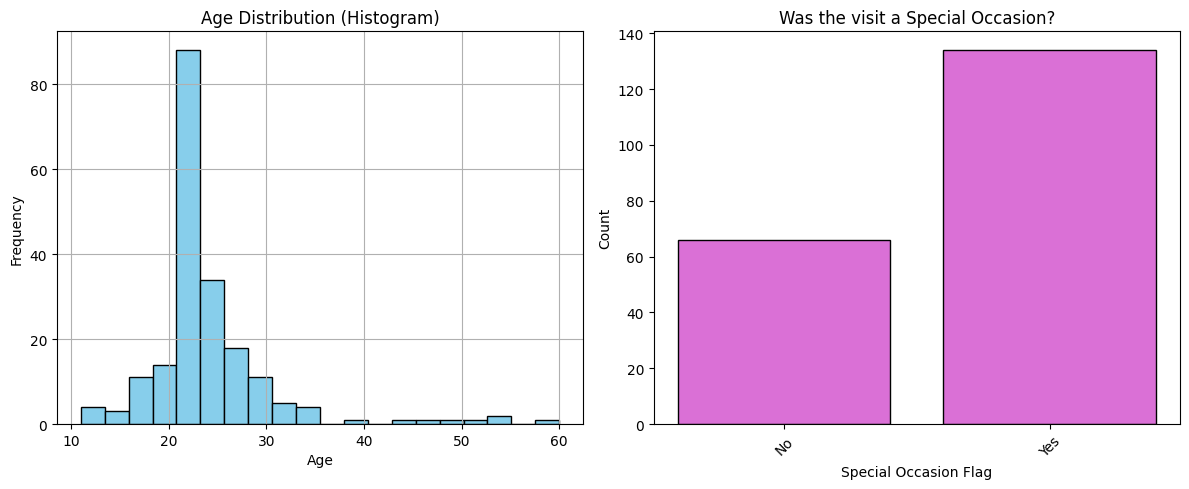

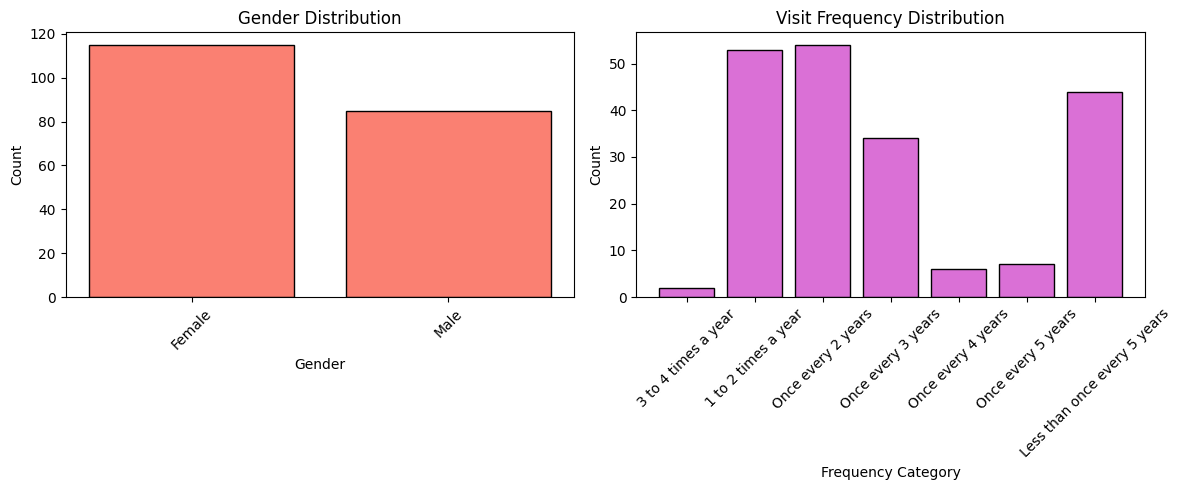

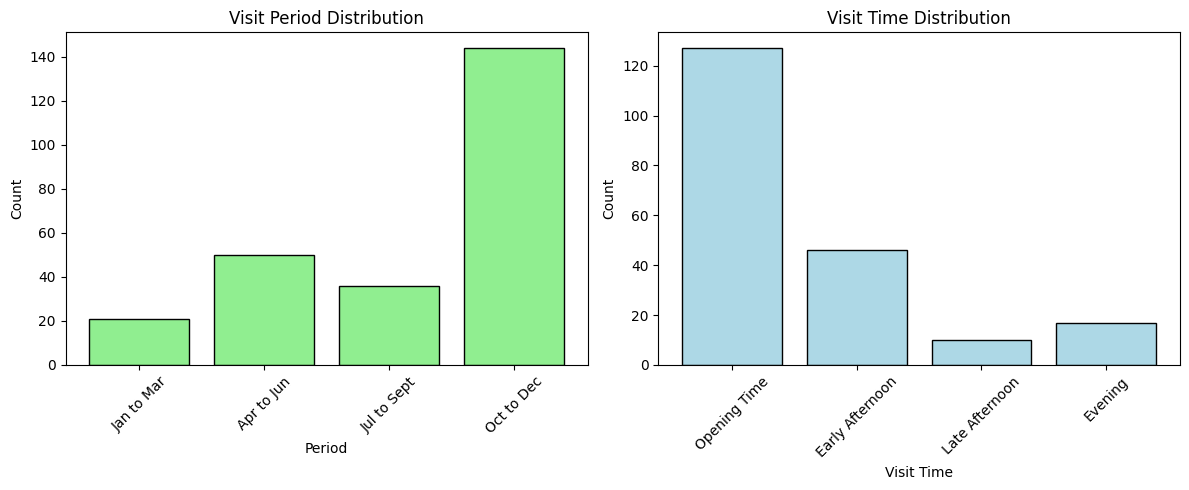

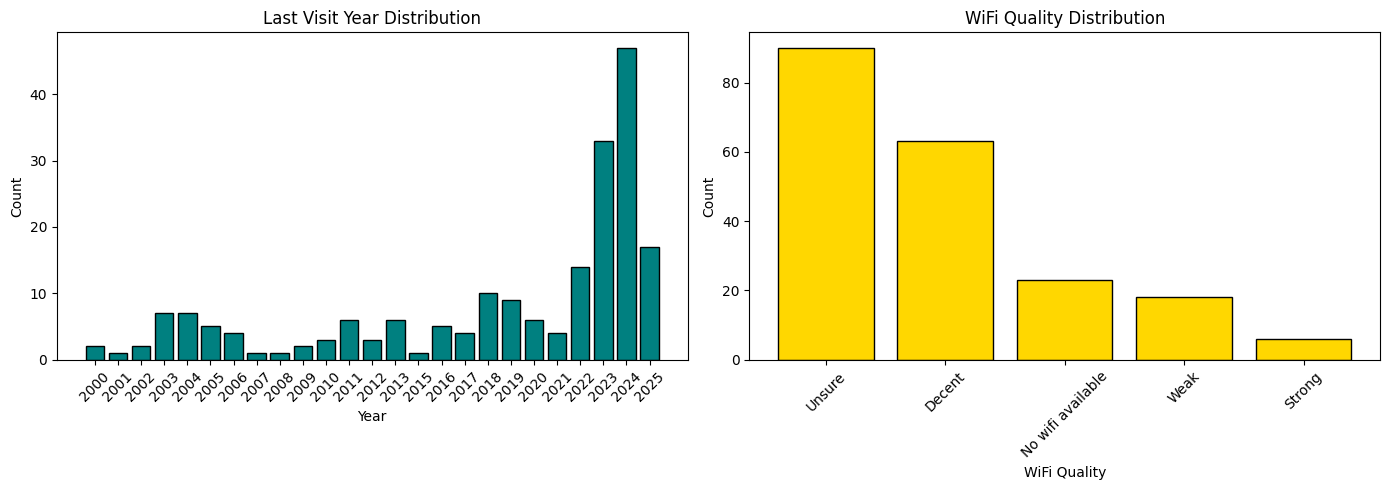

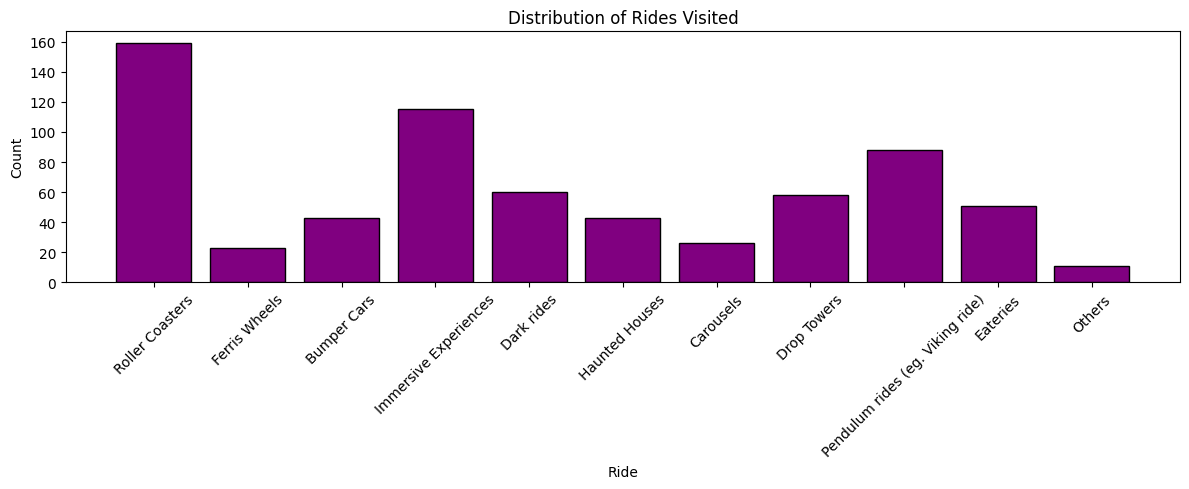

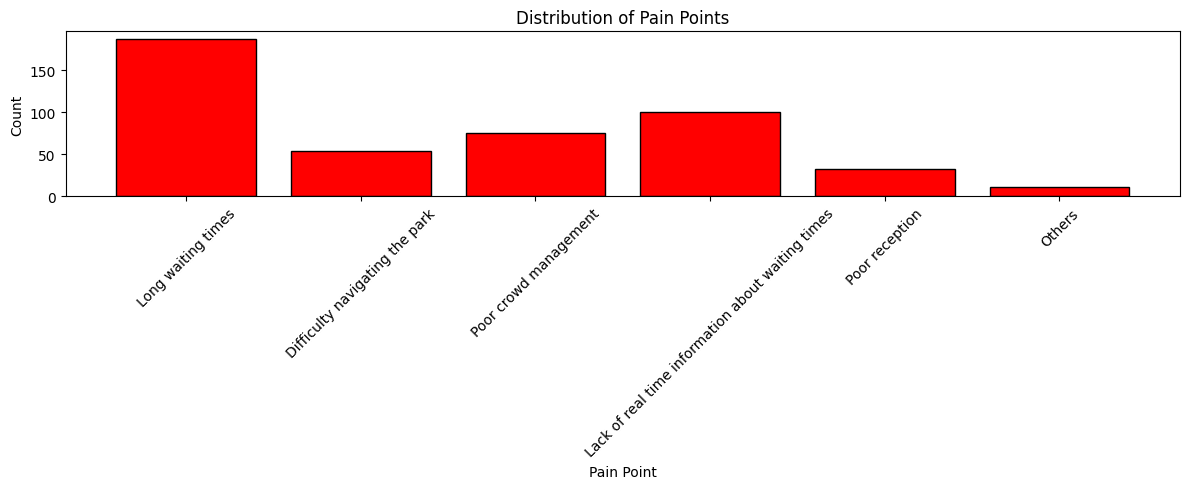

In [74]:
import matplotlib.pyplot as plt

# Create inverse mappings to get text labels from numeric codes.
inv_frequency_mapping = {v: k for k, v in frequency_mapping.items()}
inv_visit_mapping = {v: k for k, v in visit_mapping.items()}

plt.figure(figsize=(12, 5))

# Left: Histogram of Age
ax1 = plt.subplot(1, 2, 1)
ax1.hist(df['Age'].dropna(), bins=20, color='skyblue', edgecolor='black')
ax1.set_title('Age Distribution (Histogram)')
ax1.set_xlabel('Age')
ax1.set_ylabel('Frequency')
ax1.grid(True)

# Right: Special Occasion
ax2 = plt.subplot(1, 2, 2)
special_counts = df['SpecialOccasionFlag'].value_counts().sort_index()
ax2.bar(special_counts.index.astype(str), special_counts.values, color='orchid', edgecolor='black')
ax2.set_title('Was the visit a Special Occasion?')
ax2.set_xlabel('Special Occasion Flag')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))

# Left: Gender Distribution
ax1 = plt.subplot(1, 2, 1)
gender_counts = df['Gender'].value_counts()
ax1.bar(gender_counts.index.astype(str), gender_counts.values, color='salmon', edgecolor='black')
ax1.set_title('Gender Distribution')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Right: Visit Frequency Distribution (mapped as Frequency)
ax2 = plt.subplot(1, 2, 2)
freq_counts = df['Frequency'].value_counts().sort_index()
freq_labels = [inv_frequency_mapping.get(code, str(code)) for code in freq_counts.index]
ax2.bar(freq_labels, freq_counts.values, color='orchid', edgecolor='black')
ax2.set_title('Visit Frequency Distribution')
ax2.set_xlabel('Frequency Category')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 5))

# Left: Period distribution using one-hot encoded columns
ax1 = plt.subplot(1, 2, 1)
period_counts = df[periods_list].sum()
ax1.bar(period_counts.index, period_counts.values, color='lightgreen', edgecolor='black')
ax1.set_title('Visit Period Distribution')
ax1.set_xlabel('Period')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Right: Visit Time distribution
ax2 = plt.subplot(1, 2, 2)
visit_counts = df['Visit'].value_counts().sort_index()
visit_labels = [inv_visit_mapping.get(code, str(code)) for code in visit_counts.index]
ax2.bar(visit_labels, visit_counts.values, color='lightblue', edgecolor='black')
ax2.set_title('Visit Time Distribution')
ax2.set_xlabel('Visit Time')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))

def parse_last_visit(date_str):
    if not isinstance(date_str, str):
        return pd.NaT
    date_str = date_str.strip()
    formats = ['%m/%Y', '%b-%y']
    for fmt in formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except Exception:
            continue
    return pd.NaT

df['LastVisit_dt'] = df['LastVisit'].apply(parse_last_visit)
df['LastVisit_Year'] = df['LastVisit_dt'].dt.year
lastvisit_counts = df['LastVisit_Year'].dropna().value_counts().sort_index()
int_years = lastvisit_counts.index.astype(int)
str_years = int_years.astype(str)

# Left subplot: Last Visit Year Distribution
ax1 = plt.subplot(1, 2, 1)
ax1.bar(str_years, lastvisit_counts.values, color='teal', edgecolor='black')
ax1.set_title('Last Visit Year Distribution')
ax1.set_xlabel('Year')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Right: WiFi Quality Distribution
ax2 = plt.subplot(1, 2, 2)
wifi_counts = df['WiFiQuality'].value_counts()
ax2.bar(wifi_counts.index.astype(str), wifi_counts.values, color='gold', edgecolor='black')
ax2.set_title('WiFi Quality Distribution')
ax2.set_xlabel('WiFi Quality')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


# Rides Visited (Group of one-hot encoded ride columns)

rides_list = ['Roller Coasters', 'Ferris Wheels', 'Bumper Cars', 'Immersive Experiences', 
              'Dark rides', 'Haunted Houses', 'Carousels', 'Drop Towers', 
              'Pendulum rides (eg. Viking ride)', 'Eateries', 'Others']

rides_counts = df[rides_list].sum()  # Sum each one-hot column to get counts
plt.figure(figsize=(12, 5))
plt.bar(rides_counts.index, rides_counts.values, color='purple', edgecolor='black')
plt.title('Distribution of Rides Visited')
plt.xlabel('Ride')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Pain Points (Group of one-hot encoded pain point columns)
pain_list = ['Long waiting times', 'Difficulty navigating the park', 'Poor crowd management', 
             'Lack of real time information about waiting times', 'Poor reception', 'Others']

pain_counts = df[pain_list].sum()
plt.figure(figsize=(12, 5))
plt.bar(pain_counts.index, pain_counts.values, color='red', edgecolor='black')
plt.title('Distribution of Pain Points')
plt.xlabel('Pain Point')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()